In [24]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
import os
import random

In [25]:
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [26]:
with open(f"./names.txt") as file:
    words = file.readlines()
# print(words)
words = [word.strip() for word in words]
# Shuffle for training splits, inplace
random.shuffle(words)
    

In [27]:
# Store alphabet from data
alphabet = set()

# For every character of each word
for word in words:
    for char in word:
        alphabet.add(char)
        
# Add start and end tokens
alphabet.add('<S>')
alphabet.add('<E>')
alphabet = sorted(alphabet)

In [28]:
# Store numeric conversions of tokens
tok_to_int = dict()
int_to_tok = dict()

# Iterate across entire alphabet
for i, token in enumerate(alphabet):
    tok_to_int[token] = i
    int_to_tok[i] = token

In [29]:
# Define Window Size 
window_size = 3

# Store training vardiables
X = []
Y = []

#Iterate over each word
for word in words:

    # Store initial window of padding
    window = [tok_to_int["<S>"] for _ in range(window_size)]
    # Add ending token to word
    word = list(word) + ['<E>']

    # Store edge case training point
    X.append(window) 
    # Store edge case target
    Y.append(tok_to_int[word[0]]) #T
    # Iterate over each character + padding
    for char1, char2 in zip(word[:], word[1:]):
        # Store training data and targets
        # print(window)
        window = window[1:] + [tok_to_int[char1]]
        # Store window in training set
        X.append(window)
        # print(tok_to_int[char2])
        Y.append(tok_to_int[char2])

train_idx = int(.8 * len(X))
val_idx = int(.9 * len(X))


X_train = torch.tensor(X[0:train_idx]).to(device)
Y_train = torch.tensor(Y[0:train_idx]).to(device)
X_val  = torch.tensor(X[train_idx:val_idx]).to(device)
Y_val = torch.tensor(Y[train_idx:val_idx]).to(device)
X_test = torch.tensor(X[val_idx:]).to(device)
Y_test = torch.tensor(Y[val_idx:]).to(device)

In [38]:
# Define variables
len_of_emb = 10
nuerons_in_first_layer = 300
# Second layer = final layer
nuerons_in_second_layer = 28
# Store words embeddings with 2 features
C = torch.rand(len(alphabet), len_of_emb, requires_grad=True, device=device)

# # Store dataset via embeddings
# train_emb = C[X_train].view(-1, window_size*len_of_emb).to(torch.float32)
val_emb = C[X_val].view(-1, window_size*len_of_emb).to(torch.float32)
test_emb= C[X_test].view(-1, window_size*len_of_emb).to(torch.float32)

# train_emb.requires_grad_(True)
# target_emb = F.one_hot(Y, num_classes=28)

# # Store weights and bias
W1 = torch.rand(window_size*len_of_emb, nuerons_in_first_layer, requires_grad=True, dtype=torch.float32, device=device)
B1 = torch.rand(nuerons_in_first_layer, requires_grad=True, dtype=torch.float32, device=device)

W2 = torch.rand(nuerons_in_first_layer, nuerons_in_second_layer, requires_grad=True, dtype=torch.float32, device=device)
B2 = torch.rand(nuerons_in_second_layer,requires_grad=True, dtype=torch.float32, device=device)

parameters = [C, W1, W2, B1, B2]
# Check dimensions
# print(embed.T.shape, W1.shape, B1.shape)
# print(embed.T.shape, W2.shape, B2.shape)

In [39]:
# # Test out single pass 
# # Calculate linear layer
# logits = (input_emb @ W1) + B1

# # Apply Softmax
# softmax = F.softmax(logits, dim=1)

# # Calculate loss from negative log likelihood, (loss used in GLM)
# lik = softmax[torch.arange(len(softmax)), Y]

# neg_log_lik = lik.log() * -1

# loss = neg_log_lik.mean().item()

# # Calculate loss using built-in function

# simple_loss = F.cross_entropy(input=logits, target=Y)
# print(simple_loss)
# print(simple_loss.item())

In [40]:
# Optimization data : Smith's Method - Find lr comparing Low to high learning rates, selecting @ elbow point
# lr_line = torch.linspace(-3, 0, num_of_iters) # for choosing optimal lr
# lr_exp = 10 ** lr_line #this transformations yields values between .001 and 1

def mini_batch(size=64):
    indices = torch.randint(0, X_train.shape[0], (size,), device=device)
    batch_X = X_train[indices]
    batch_input_emb = C[batch_X].view(-1, window_size*len_of_emb).to(torch.float32)
    return batch_input_emb, Y_train[indices]

# define foward pass
def foward_pass(inputs):
    # First Layer
    int_result = F.tanh((inputs @ W1) + B1)
    # Second/Output Layer
    logits = (int_result @ W2) + B2
    return logits

# Training parameters
num_of_iters = 200000
best_val_score = float('inf')
batch_size = 64
lr = 10 ** -4
patience = 1000 # consecutive !!
strikes = 0
train_loss_stats = []
val_loss_stats = [] # should be smooth, given constraints


In [41]:
# Training for num_of_iters passes through a minibatches of the data
for step in range(num_of_iters):
    # Get mini batch
    training_data, targets = mini_batch(batch_size)
    training_data.to(device)
    targets.to(device)
    # Zero out gradients
    for p in parameters:
        if p.grad is not None:
            param.grad.zero_() #inplace
    # Foward pass
    logits = foward_pass(training_data)
    # Calculate Loss (Note: learned about two function "log_softmax" and "F.nll_loss")
    train_loss = F.cross_entropy(input=logits, target=targets, reduction='mean')
    # backpropogation
    train_loss.backward()
    train_loss_stats.append(train_loss.item())
    # Gradient clipping for eploding gradients
    torch.nn.utils.clip_grad_norm_(parameters, max_norm=1.0)

    # Foward pass
    val_logits = foward_pass(val_emb)
    # Calculate val loss
    val_loss = F.cross_entropy(input=val_logits, target=Y_val, reduction='mean')
    # add val loss
    val_loss_stats.append(val_loss.item())
    
    
    lr = .01 if step < 100000 else .01
    # update weights give learning rate
    for p in parameters:
        # Ensure updates arent added to computation graph
        with torch.no_grad():
            for param in parameters:
                # update in the opposite direction of the gradient
                param -= lr * param.grad
    
    
    # Early stopping
    if val_loss < best_val_score: # decreasing
        # set best validation loss to recent val loss
        best_val_score = val_loss
        strikes = 0 # reset scores
    else: # increasing, no update to best score
        strikes += 1
        if strikes >= patience: # Patience threshold exceeded
        # Terminate training
            print(f"Training Terminated on iteration {step}.")
            print(f" Training Loss: {train_loss}")
            print(f" Validation Loss: {val_loss}")
            break

    # Output stats 
    if step % 500 == 0:
        # Output training info
        print(F"Number of iterations: {step}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

Number of iterations: 0, Training Loss: 10.41179370880127, Validation Loss: 10.31005573272705
Number of iterations: 500, Training Loss: 2.953190803527832, Validation Loss: 2.9022035598754883
Number of iterations: 1000, Training Loss: 2.778201103210449, Validation Loss: 2.8661015033721924
Number of iterations: 1500, Training Loss: 2.861539840698242, Validation Loss: 2.8708598613739014
Number of iterations: 2000, Training Loss: 2.6556735038757324, Validation Loss: 2.86226749420166
Training Terminated on iteration 2004.
 Training Loss: 2.862447738647461
 Validation Loss: 2.8433361053466797


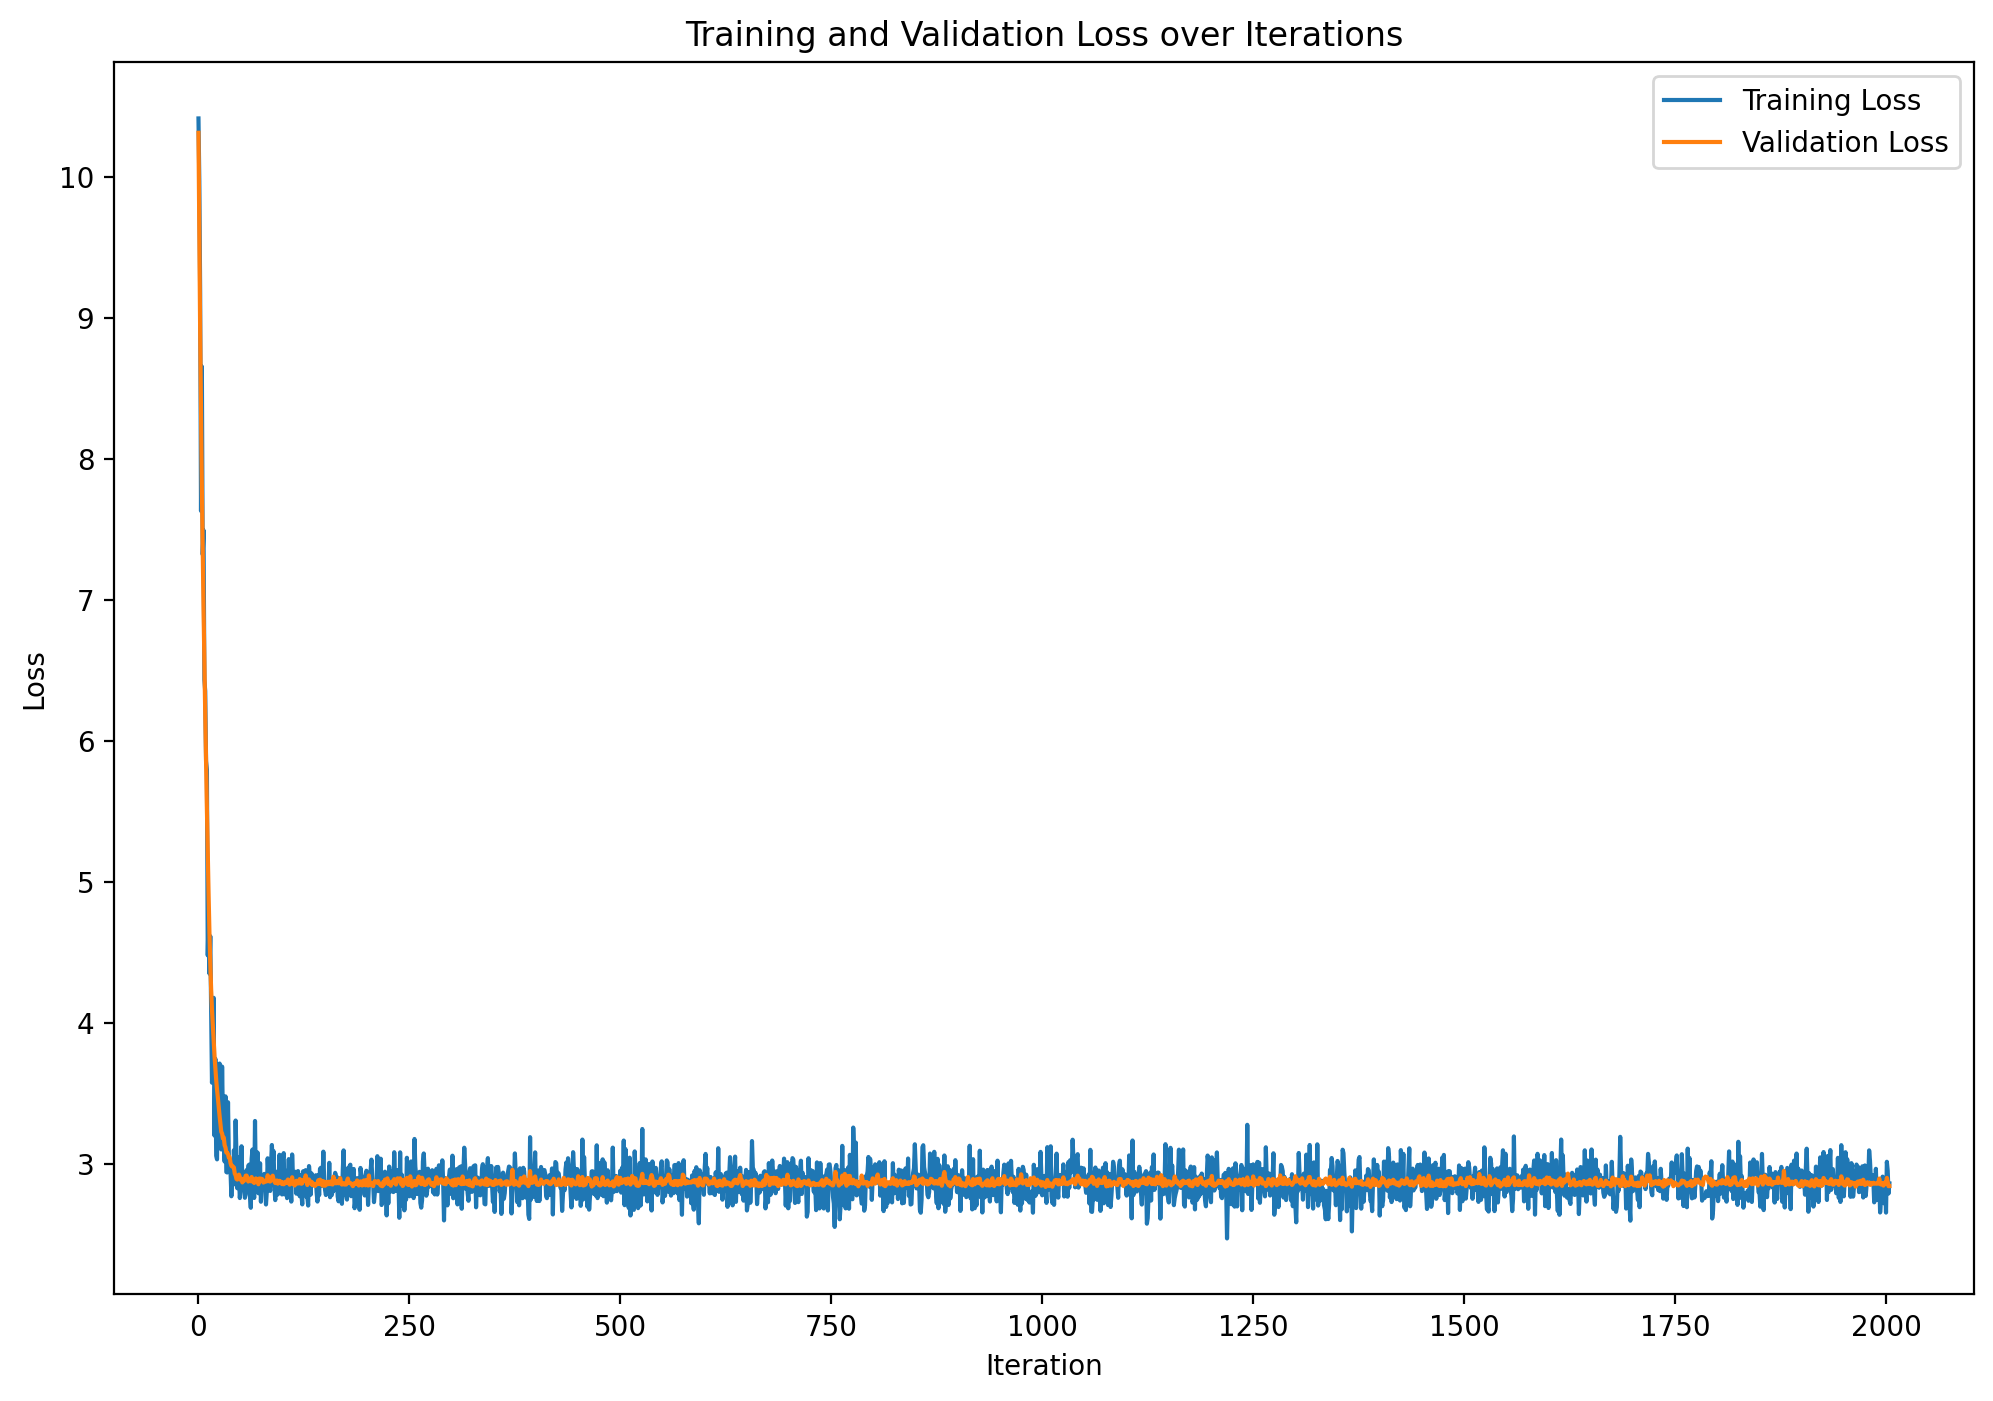

In [46]:
plt.figure(figsize=(12, 8), dpi=200)  
# Plot loss over steps
plt.plot(train_loss_stats, label='Training Loss')
plt.plot(val_loss_stats, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Iterations')
plt.legend()
plt.show()